In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Loading Data
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")


### Shape of data

In [ ]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


**Basic Understanding**

Training data consists of 2115 datapoints.
Test data consists of 443 datapoints.

Each datapoint is a trial:

*   Input -> Has dimension 22*1000 representing EEG data from 22 electrodes over 1000 time bins.
*   Output -> A category (4 categories total) that represents the action the user was thinking about during this trial. Currently the possible outputs/labels are (769, 770, 771, 772).

The person files correspond to the subject performing the task, ranging from 0-8 (inclusive).

Trials that have NaNs are already removed.

### Data Processing

Adjust Labels

In [ ]:
# Adjusting the labels so that:
# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

In [ ]:
# Helper function for visualizing the data for a channel
def plot_channel_data(channel):
  if(channel >= 22 or channel < 0):
    return

  print("Channel: ", channel)
  ch_data = X_train_valid[:,channel,:]

  class_0_ind = np.where(y_train_valid == 0)
  ch_data_class_0 = ch_data[class_0_ind]
  avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)
  print(avg_ch_data_class_0.shape)


  class_1_ind = np.where(y_train_valid == 1)
  ch_data_class_1 = ch_data[class_1_ind]
  avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)
  print(avg_ch_data_class_1.shape)

  class_2_ind = np.where(y_train_valid == 2)
  ch_data_class_2 = ch_data[class_2_ind]
  avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)
  print(avg_ch_data_class_2.shape)

  class_3_ind = np.where(y_train_valid == 3)
  ch_data_class_3 = ch_data[class_3_ind]
  avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)
  print(avg_ch_data_class_3.shape)


  plt.plot(np.arange(1000),avg_ch_data_class_0)
  plt.plot(np.arange(1000),avg_ch_data_class_1)
  plt.plot(np.arange(1000),avg_ch_data_class_2)
  plt.plot(np.arange(1000),avg_ch_data_class_3)
  plt.axvline(x=500, label='line at t=500',c='cyan')

  plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

Channel:  0
(1000,)
(1000,)
(1000,)
(1000,)


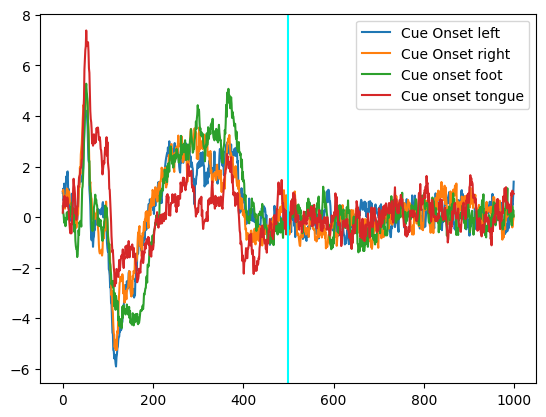

In [ ]:
plot_channel_data(0)

Channel:  10
(1000,)
(1000,)
(1000,)
(1000,)


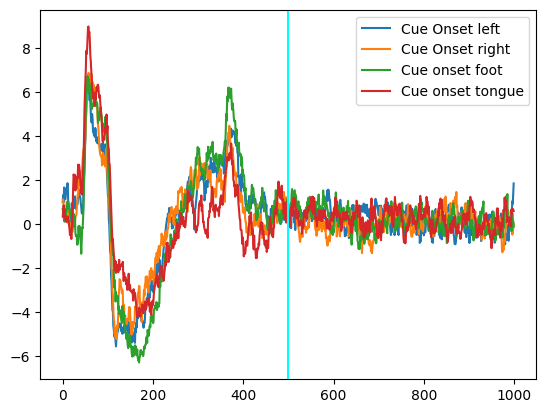

In [ ]:
plot_channel_data(10)

Channel:  20
(1000,)
(1000,)
(1000,)
(1000,)


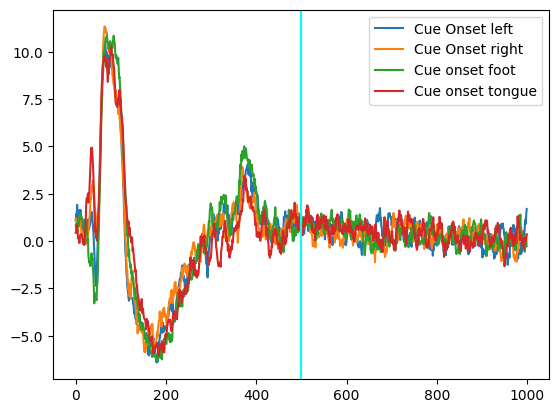

In [ ]:
plot_channel_data(20)

**Ideas about data from the above plots:**

From sampling particular channels/electrodes we plotted curves respresenting the average electrode reading per time bin across all datapoints of a particular label.

It can be seen that these curves seem to form a roughly uniform shape upto time bin 500 after which the average electrode reading seems to fluctuate around value 0 like noise.

This suggests that one way to process data is to only utilize the first 500 time bins.

### Defining data processing helper code for common use

We first split the train data into train and validation data and then preprocess/augment data. This way we can avoid data leakage.

Although it looks likes after 500 time bins the channel/electrode signals become noisy, we decided to crop out only the last 200 time bins. This is because we want to implement filtering which will further reduce the time dimension and we do not want the final time dimension to be too low.

We apply low pass filtering through max pooling in the time dimension.

One thing we notice about this data is that it is quite small. Like only around 2100 trials to train/validate with. Hence data augmentation techniques may be useful. We use averaging and subsampling across time dimension to get new inputs with same dimension as filtered inputs and same corresponding labels

Since we are working with non-invasive EEG signals, there will be a lot of noise in the data. Hence, we could make augmented data more realistic by adding noise.

**Concise description of final data processing helper our team uses:**

**Train Data Processing**
*   Adjust labels so that they are in range 0 to 4 instead of 769 to 772.
*   Remove that last 200 time bins.
*   Apply max pool low pass filter across time dimension.
*   Apply average low pass filter across time dimension and add noise to this.
*   Augment average filtered plus noise added data to max pool filtered data.
*   Apply subsampling in time dimension and optionally add noise. Augment this to above to form final training data.

*Note about noise: This is guassian noise with mean 0 and standard deviation 0.05.*

**Test Data Processing**
*   Adjust labels so that they are in range 0 to 4 instead of 769 to 772.
*   Remove that last 200 time bins.
*   Apply max pool low pass filter across time dimension.

*Note: Data Augmentation techniques do not apply to test data.*

**Final data processing code provided below**

**How our team calls the code:** train_data_prep(X,y,p), test_data_prep(X,y,p)

Note: We decide to add noise and filter/subsample such that the final data is reduced in time dimension only by half (800 to 400).

In [ ]:
def train_data_prep(X,y,p,sub_sample=2,average=2,noise=True):

    # Adjusting labels
    y -= 769

    total_X = None
    total_y = None
    total_p = None

    # Cropping the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data in time dimension (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)

    total_X = X_max
    total_y = y
    total_p = p
    print('Shape of X after maxpooling:',total_X.shape)

    # Averaging original data + adding noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)

    # Augmenting averaged data with noise to max pool filtered data
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    total_p = np.vstack((total_p, p))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    # Subsampling + optionally adding noise
    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
        # augmenting subsampled plus optionally noise added data
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        total_p = np.vstack((total_p, p))

    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    print('Shape of P:',total_p.shape)

    return total_X, total_y, total_p


def test_data_prep(X, y, p, sub_sample=2):

    #Adjusting labels
    total_y = y - 769
    total_p = p
    total_X = None

    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)

    return total_X, total_y, total_p

For particular libraries we may need to do operations like convert labels to categorical or add a dimension or reshape.